# NID Feature Analysis Demo

Intention here is to present an example of a work analysis. There was interest in bolstering our predictive model with more infrastructure data. Specifically, I was looking at the **National Inventory of Dams** and the **National Bridge Inventory** datasets. 

What might the correlation look like between dams of poor condition and the damages an area underwent during a severe storm? Could these datasets be used to inform a model, or would they be redundant compared to what was already used?

This notebook won't contain all of the analysis. In fact, I can really only showcase the data cleaning efforts and exploration of this large dataset. The NID data has roughly 80 columns and 90,000 rows and the data entered is not always in the correct form. 

Gathering information that I could use was a challenge, but the reward was well worth it. We were able to use the dam data, in conjunction with USGS river gauge data, to aid efforts during Hurricane Helene and identify areas in need. 

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gp
import contextily as con
from datetime import datetime
from pathlib import Path

import mapclassify


In [159]:
plt.style.use('dark_background')
plt.rc(
    "figure",
    autolayout=True,
    figsize=(20, 10),
    titlesize=25,
    titleweight='normal'
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="larger",
    titleweight="bold",
    titlesize=20,
    titlepad=15
)
plt.rcParams['axes.grid'] = False
plt.rcParams['font.family'] = 'serif'
%config InlineBackend.figure_format = 'retina'

In [160]:
dir = Path('/Users/bensalis/Downloads/nation.csv')
df = pd.read_csv(dir, usecols = ['Dam Name', 'NID ID', 'State', 'County', 'Longitude', 'Latitude', 'Owner Types',
                                'Dam Height (Ft)', 'Dam Length (Ft)', 'Volume (Cubic Yards)',
                                'Year Completed', 'Data Last Updated', 'Last Inspection Date', 'Inspection Frequency',
                                'Hazard Potential Classification', 'Condition Assessment'])

In [161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92583 entries, 0 to 92582
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Dam Name                         88243 non-null  object 
 1   NID ID                           92581 non-null  object 
 2   Owner Types                      92573 non-null  object 
 3   Latitude                         92424 non-null  float64
 4   Longitude                        92426 non-null  float64
 5   State                            92583 non-null  object 
 6   County                           92425 non-null  object 
 7   Dam Height (Ft)                  82602 non-null  float64
 8   Dam Length (Ft)                  78755 non-null  float64
 9   Volume (Cubic Yards)             45319 non-null  float64
 10  Year Completed                   73674 non-null  float64
 11  Data Last Updated                92583 non-null  object 
 12  Last Inspection Da

In [162]:
df['Condition Assessment'].unique()

array(['Not Rated', nan, 'Not Available', 'Satisfactory', 'Fair',
       'Unsatisfactory', 'Poor'], dtype=object)

In [163]:
df['Hazard Potential Classification'].unique()

array(['Low', 'High', 'Significant', 'Undetermined', nan], dtype=object)

In [164]:
filter = (
    (df['Condition Assessment'].isin(['Unsatisfactory', 'Poor', 'Satisfactory', 'Fair'])) & (
    df['Hazard Potential Classification'].isin(['Low', 'Significant', 'High']))
    )

filter.sum() #filters out about 60k dams

33858

In [165]:
#Converting to ordinal values to prepare for aggregation later. 
primary = df[filter].copy()
primary['Condition Assessment'].replace(['Unsatisfactory', 'Poor', 'Satisfactory', 'Fair'], [0,1,2,3], inplace= True)
primary['Hazard Potential Classification'].replace(['Low', 'Significant','High'], [0, 1, 2], inplace= True)

primary.head()

Dam Name   NID ID Owner Types   Latitude  Longitude  \
8   Asso.Minerals (Usa) Ltd. Dam  FL00155     Private  29.890339 -81.706600   
11        Girl Scouts of Usa Dam  NC02637     Private  35.235600 -81.265000   
12                Engineer Lake   LA00171     Federal  31.120193 -93.077118   
13                        Dam 29  TX07242     Federal  31.181977 -97.849519   
15               Alligator Lake   LA00170     Federal  31.144632 -93.153289   

             State   County  Dam Height (Ft)  Dam Length (Ft)  \
8          Florida     Clay             20.0          11170.0   
11  North Carolina   Gaston              NaN            290.0   
12       Louisiana   Vernon             23.0            700.0   
13           Texas  Coryell             26.0            525.0   
15       Louisiana   Vernon             34.0           1000.0   

    Volume (Cubic Yards)  Year Completed Data Last Updated  \
8                 2220.0          1970.0        05/04/2023   
11                   NaN          1982.0        06/09/2025   
12                   NaN          1964.0        05/30/2024   
13               10111.0          1995.0        05/30/2024   
15                   NaN          1955.0        05/30/2024   

   Last Inspection Date  Inspection Frequency  \
8            07/31/2014                   NaN   
11           01/16/2025                   NaN   
12           04/29/2019                   4.0   
13           09/14/2020                   4.0   
15           04/28/2019                   4.0   

    Hazard Potential Classification  Condition Assessment  
8                                 1                     2  
11                                2                     3  
12                                0                     0  
13                                0                     3  
15                                0                     1

In [166]:
primary['Last Inspection Date'] = pd.to_datetime(df['Last Inspection Date'], errors= 'coerce')
primary['Data Last Updated'] = pd.to_datetime(df['Data Last Updated'])

today = datetime.today()
primary['age_yrs'] = 2026 - primary['Year Completed']
primary['yrs_since_insp'] = np.round(primary['Last Inspection Date'].apply(lambda x: (today - x).days / 365), 2)
primary['yrs_data_update'] = np.round(primary['Data Last Updated'].apply(lambda x: (today - x).days / 365), 2)

primary.sort_values(by = 'age_yrs',ascending= False, inplace= True)
primary.reset_index(drop= True, inplace= True)

primary.head()

Dam Name   NID ID       Owner Types   Latitude  Longitude  \
0          Ipswich Mills Dam  MA00231  Local Government  42.677671 -70.837774   
1  Old Oaken Bucket Pond Dam  MA01041  Local Government  42.177578 -70.750268   
2      Lower Shawme Lake Dam  MA02470  Local Government  41.757730 -70.500454   
3         Central Street Dam  MA00340           Private  42.324916 -71.401548   
4               Nye Pond Dam  MA02469             State  41.728471 -70.431703   

           State      County  Dam Height (Ft)  Dam Length (Ft)  \
0  Massachusetts       Essex              NaN            180.0   
1  Massachusetts    Plymouth              NaN            370.0   
2  Massachusetts  Barnstable              NaN            120.0   
3  Massachusetts   Middlesex              NaN            400.0   
4  Massachusetts  Barnstable              NaN            230.0   

   Volume (Cubic Yards)  Year Completed Data Last Updated  \
0                   NaN          1637.0        2024-08-28   
1                   NaN          1640.0        2024-08-28   
2                   NaN          1654.0        2024-08-28   
3                   NaN          1659.0        2024-08-28   
4                   NaN          1669.0        2024-08-28   

  Last Inspection Date  Inspection Frequency  Hazard Potential Classification  \
0           2020-09-04                  10.0                                0   
1           2018-04-05                   5.0                                1   
2           2019-06-11                   5.0                                1   
3           2024-03-22                   2.0                                2   
4           2020-03-18                   5.0                                1   

   Condition Assessment  age_yrs  yrs_since_insp  yrs_data_update  
0                     3    389.0            5.38              1.4  
1                     2    386.0            7.80              1.4  
2                     2    372.0            6.62              1.4  
3                     3    367.0            1.84              1.4  
4                     1    357.0            5.85              1.4

In [167]:
geo_df = gp.GeoDataFrame(primary, geometry=gp.points_from_xy(x = primary.Longitude, y = primary.Latitude), crs=4326).drop(columns = ['Latitude','Longitude'])
geo_df.head()

Dam Name   NID ID       Owner Types          State  \
0          Ipswich Mills Dam  MA00231  Local Government  Massachusetts   
1  Old Oaken Bucket Pond Dam  MA01041  Local Government  Massachusetts   
2      Lower Shawme Lake Dam  MA02470  Local Government  Massachusetts   
3         Central Street Dam  MA00340           Private  Massachusetts   
4               Nye Pond Dam  MA02469             State  Massachusetts   

       County  Dam Height (Ft)  Dam Length (Ft)  Volume (Cubic Yards)  \
0       Essex              NaN            180.0                   NaN   
1    Plymouth              NaN            370.0                   NaN   
2  Barnstable              NaN            120.0                   NaN   
3   Middlesex              NaN            400.0                   NaN   
4  Barnstable              NaN            230.0                   NaN   

   Year Completed Data Last Updated Last Inspection Date  \
0          1637.0        2024-08-28           2020-09-04   
1          1640.0        2024-08-28           2018-04-05   
2          1654.0        2024-08-28           2019-06-11   
3          1659.0        2024-08-28           2024-03-22   
4          1669.0        2024-08-28           2020-03-18   

   Inspection Frequency  Hazard Potential Classification  \
0                  10.0                                0   
1                   5.0                                1   
2                   5.0                                1   
3                   2.0                                2   
4                   5.0                                1   

   Condition Assessment  age_yrs  yrs_since_insp  yrs_data_update  \
0                     3    389.0            5.38              1.4   
1                     2    386.0            7.80              1.4   
2                     2    372.0            6.62              1.4   
3                     3    367.0            1.84              1.4   
4                     1    357.0            5.85              1.4   

                     geometry  
0  POINT (-70.83777 42.67767)  
1  POINT (-70.75027 42.17758)  
2  POINT (-70.50045 41.75773)  
3  POINT (-71.40155 42.32492)  
4   POINT (-70.4317 41.72847)

In [168]:
geo_df.State.unique() #only looking at CONUS states for right now... Will confine coordinates.

array(['Massachusetts', 'Connecticut', 'Maryland', 'New Jersey',
       'New Hampshire', 'North Carolina', 'Pennsylvania', 'Maine',
       'South Carolina', 'Rhode Island', 'New York', 'Wisconsin',
       'Delaware', 'Vermont', 'West Virginia', 'Indiana', 'Michigan',
       'Ohio', 'Kentucky', 'Georgia', 'Virginia', 'Texas', 'California',
       'Minnesota', 'Idaho', 'Kansas', 'Colorado', 'Utah', 'Iowa',
       'Illinois', 'Arkansas', 'Arizona', 'Nebraska', 'Washington',
       'Nevada', 'Hawaii', 'Montana', 'Wyoming', 'New Mexico', 'Oregon',
       'North Dakota', 'Tennessee', 'Louisiana', 'Mississippi',
       'Oklahoma', 'Alaska', 'Missouri', 'South Dakota', 'Puerto Rico',
       'Alabama', 'Florida', 'Guam'], dtype=object)

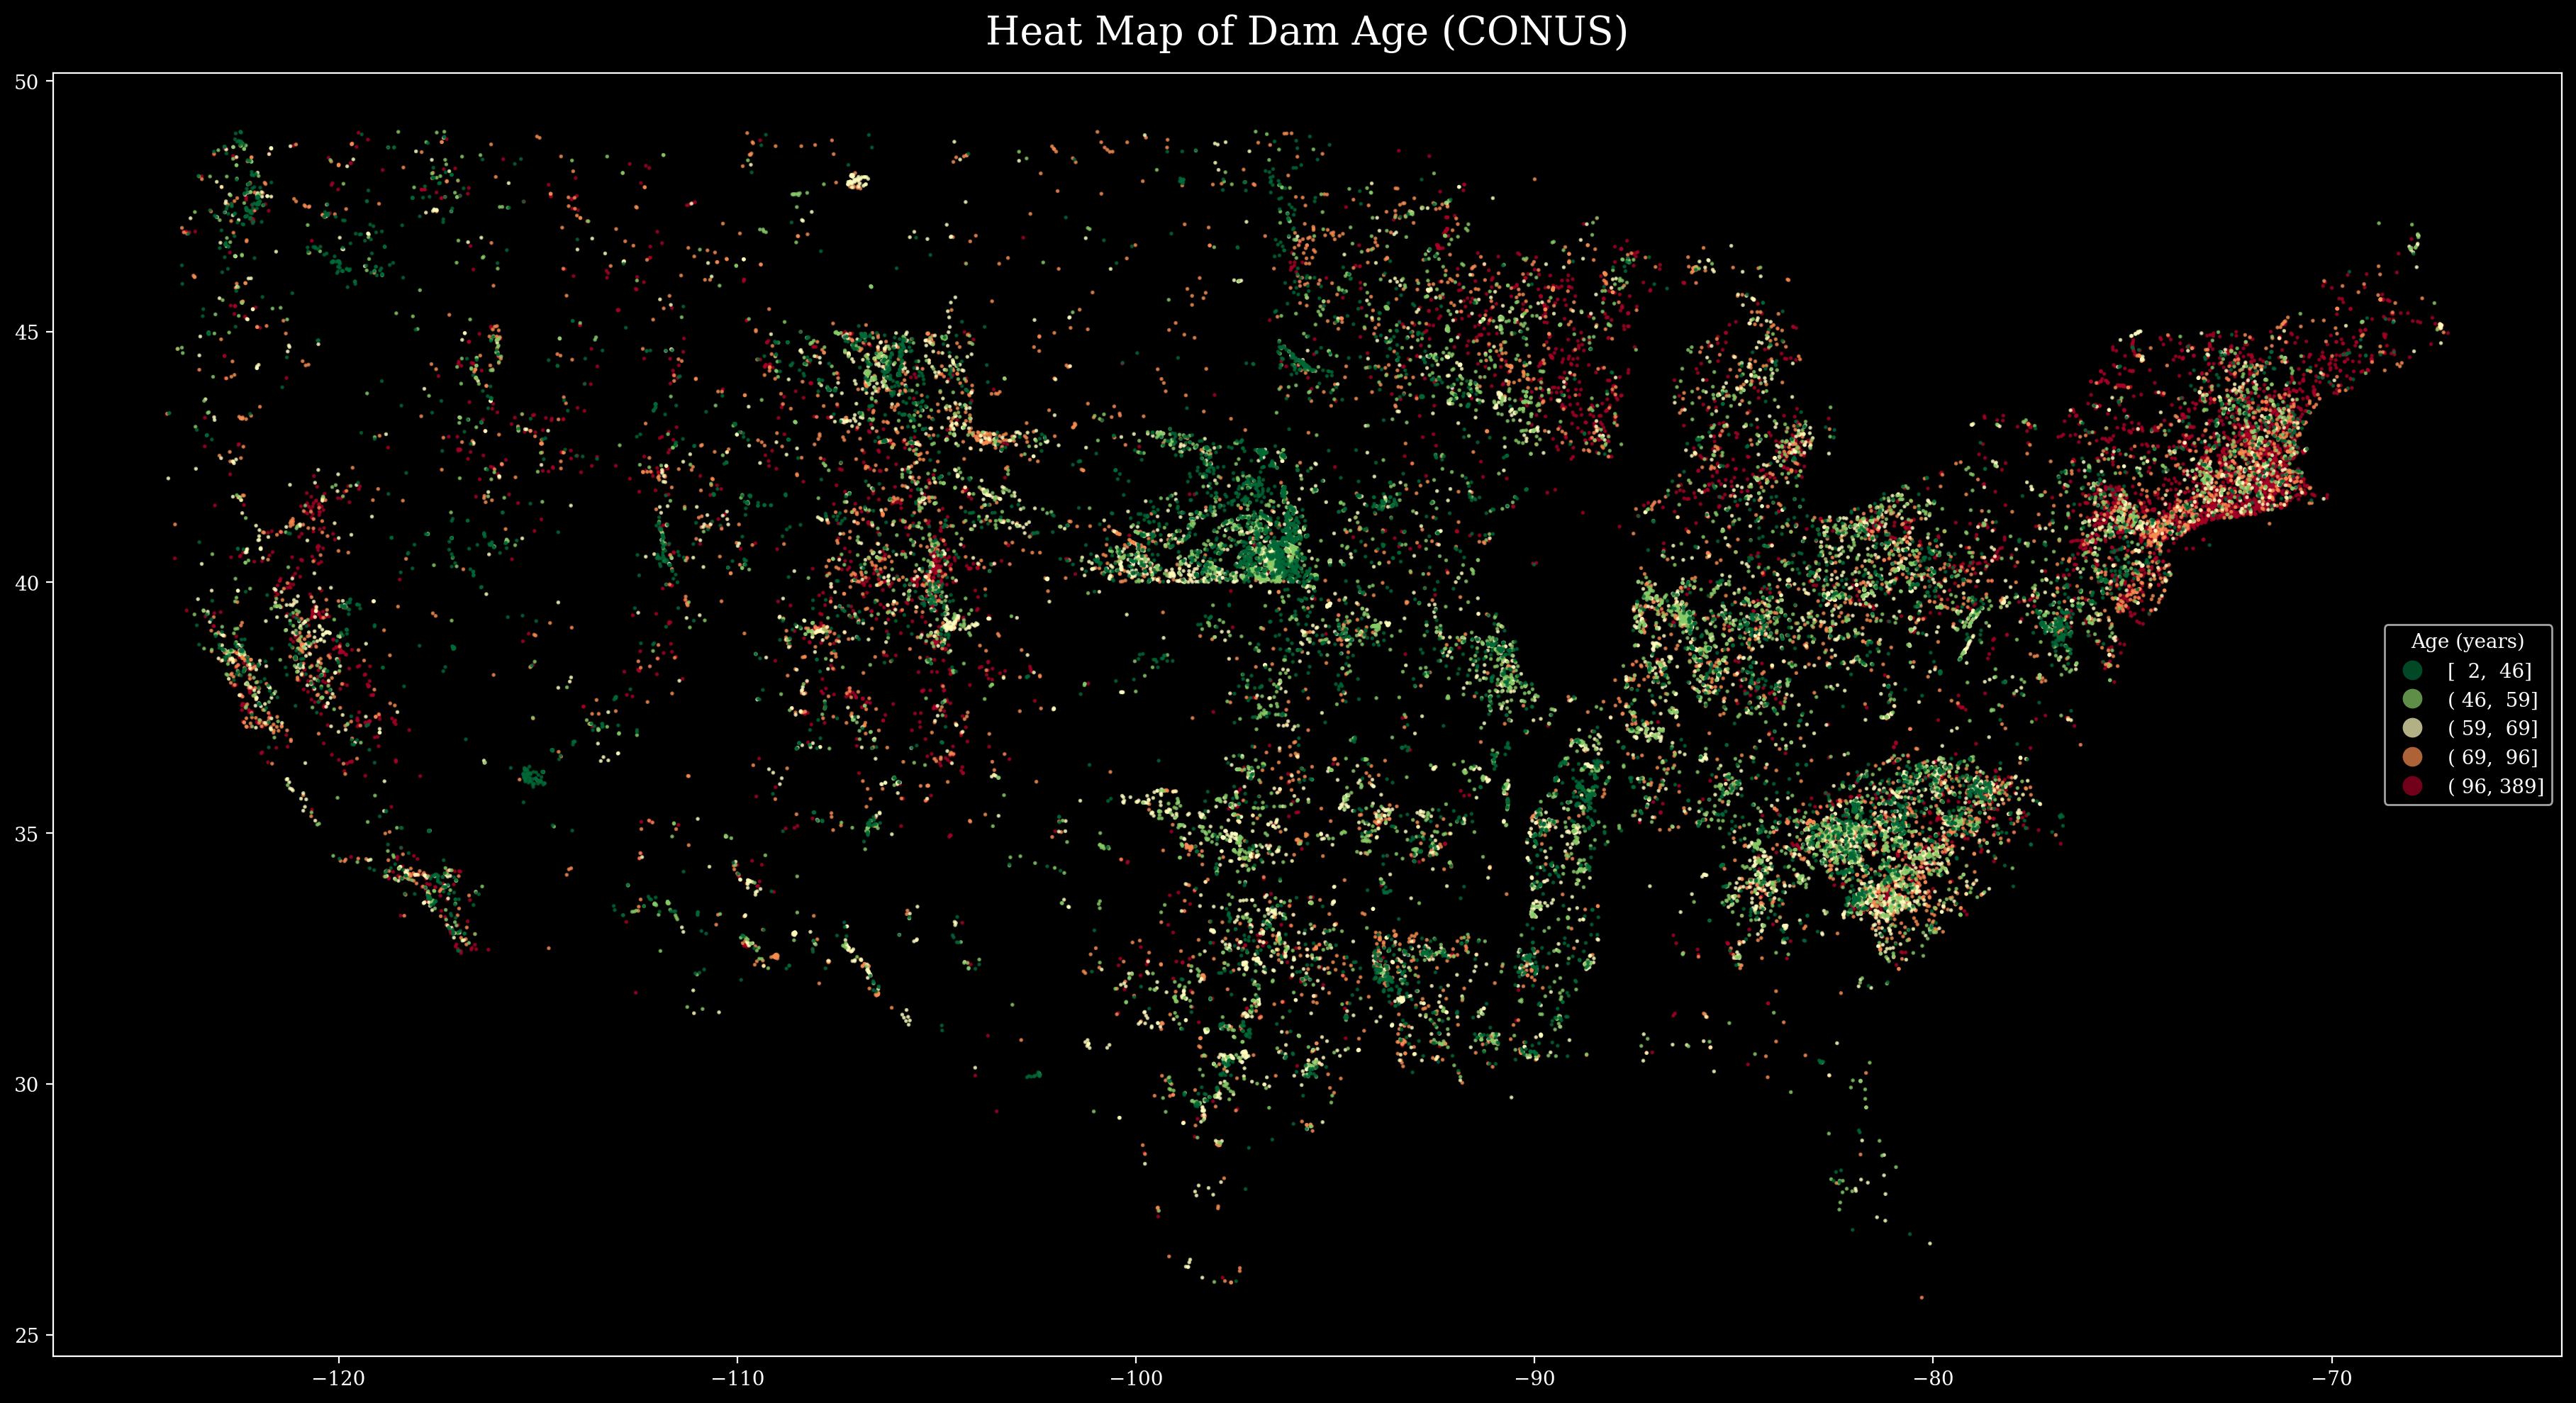

In [197]:
mask = (geo_df.geometry.x > -125) & (geo_df.geometry.x < -67) & (geo_df.geometry.y > 25)
ax = geo_df[mask].plot(column= 'age_yrs', cmap = 'RdYlGn_r',scheme='quantiles', markersize = 1, alpha = 0.7,
                       legend= True, legend_kwds={'loc':'center right', 'interval':True, 'fmt':'{:.0f}'})
ax.set_title('Heat Map of Dam Age (CONUS)', fontdict={'fontweight':'normal'})

leg = ax.get_legend()
leg.set_title('Age (years)')
plt.show()
#taking a look at geographic distributions. Nothing too helpful

<Figure size 2000x1000 with 0 Axes>

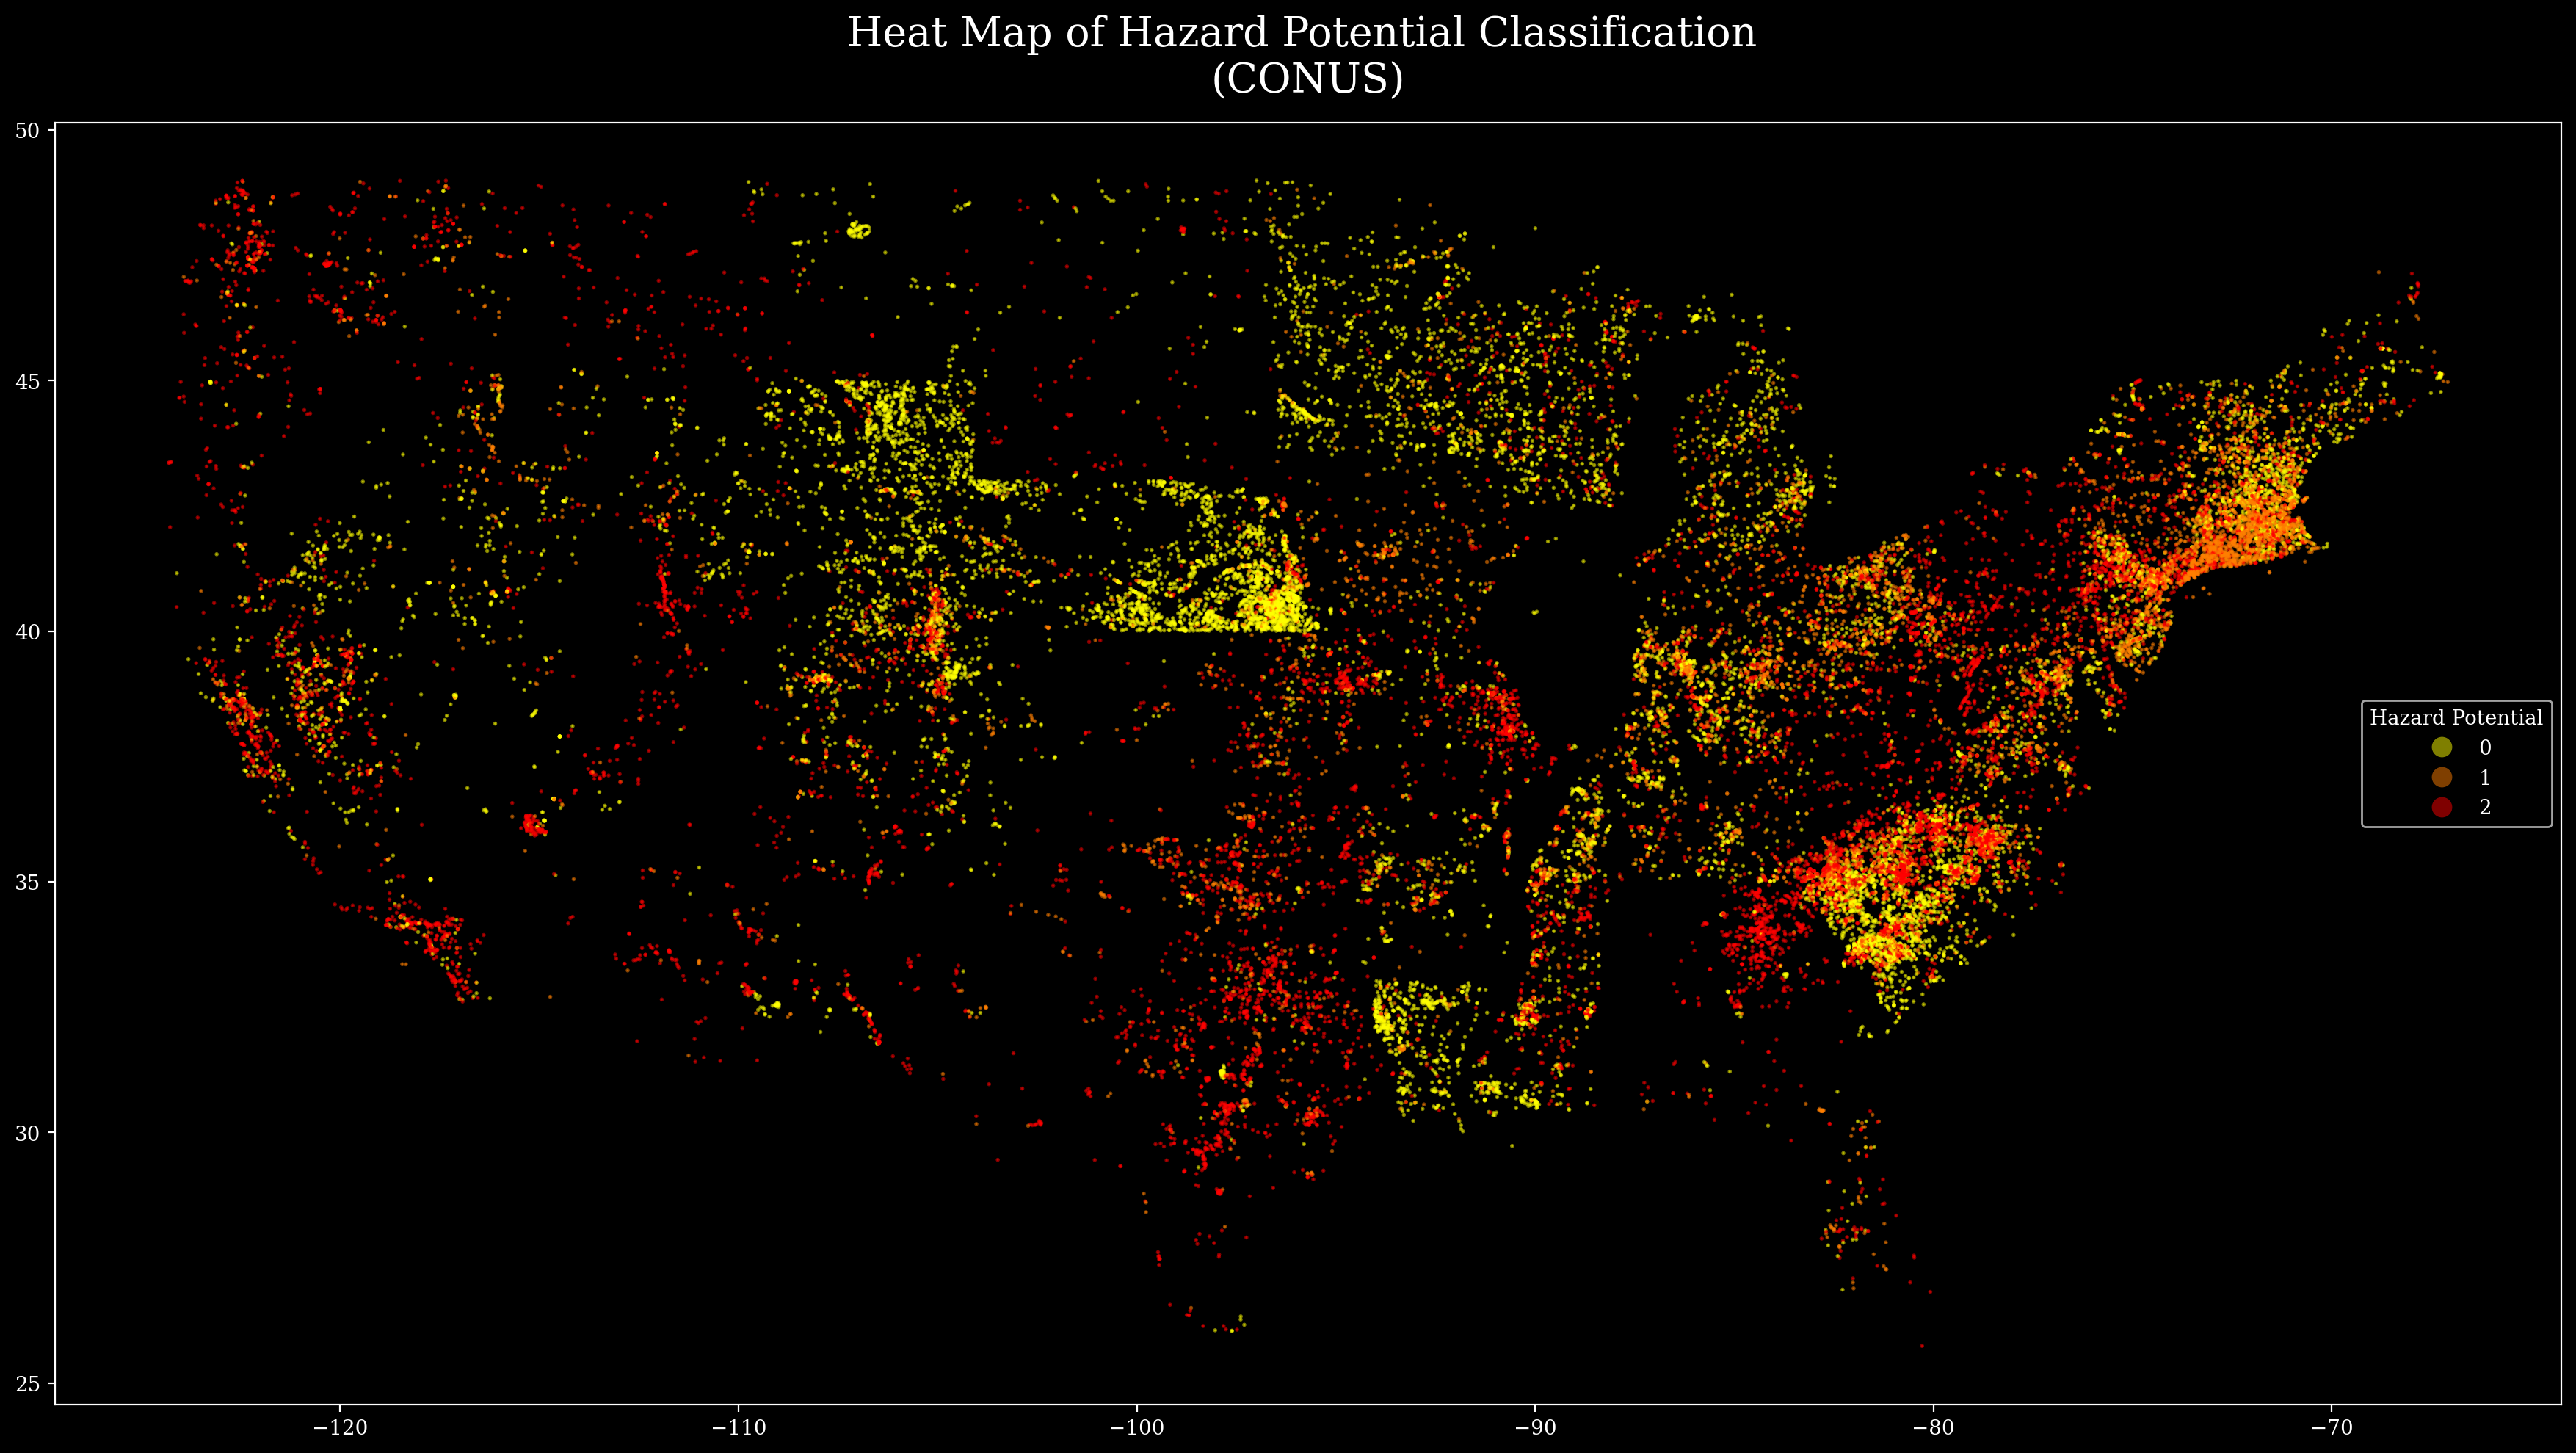

In [ ]:
plt.clf()
ax = geo_df[mask].plot(column= 'Hazard Potential Classification', cmap = 'autumn_r', categorical= True, markersize = 1, alpha = 0.5,
                       legend= True, legend_kwds={'loc':'center right', 'fmt':'{:.0f}'})
ax.set_title('Heat Map of Hazard Potential Classification \n(CONUS)', fontdict={'fontweight':'normal'})

leg = ax.get_legend()
leg.set_title('Hazard Potential')
plt.show()

# Note: Low Hazard Potential -> Significant -> High Hazard Potential 
# Significant Hazard Potential dams are more common in the northeast.

<Figure size 2000x1000 with 0 Axes>

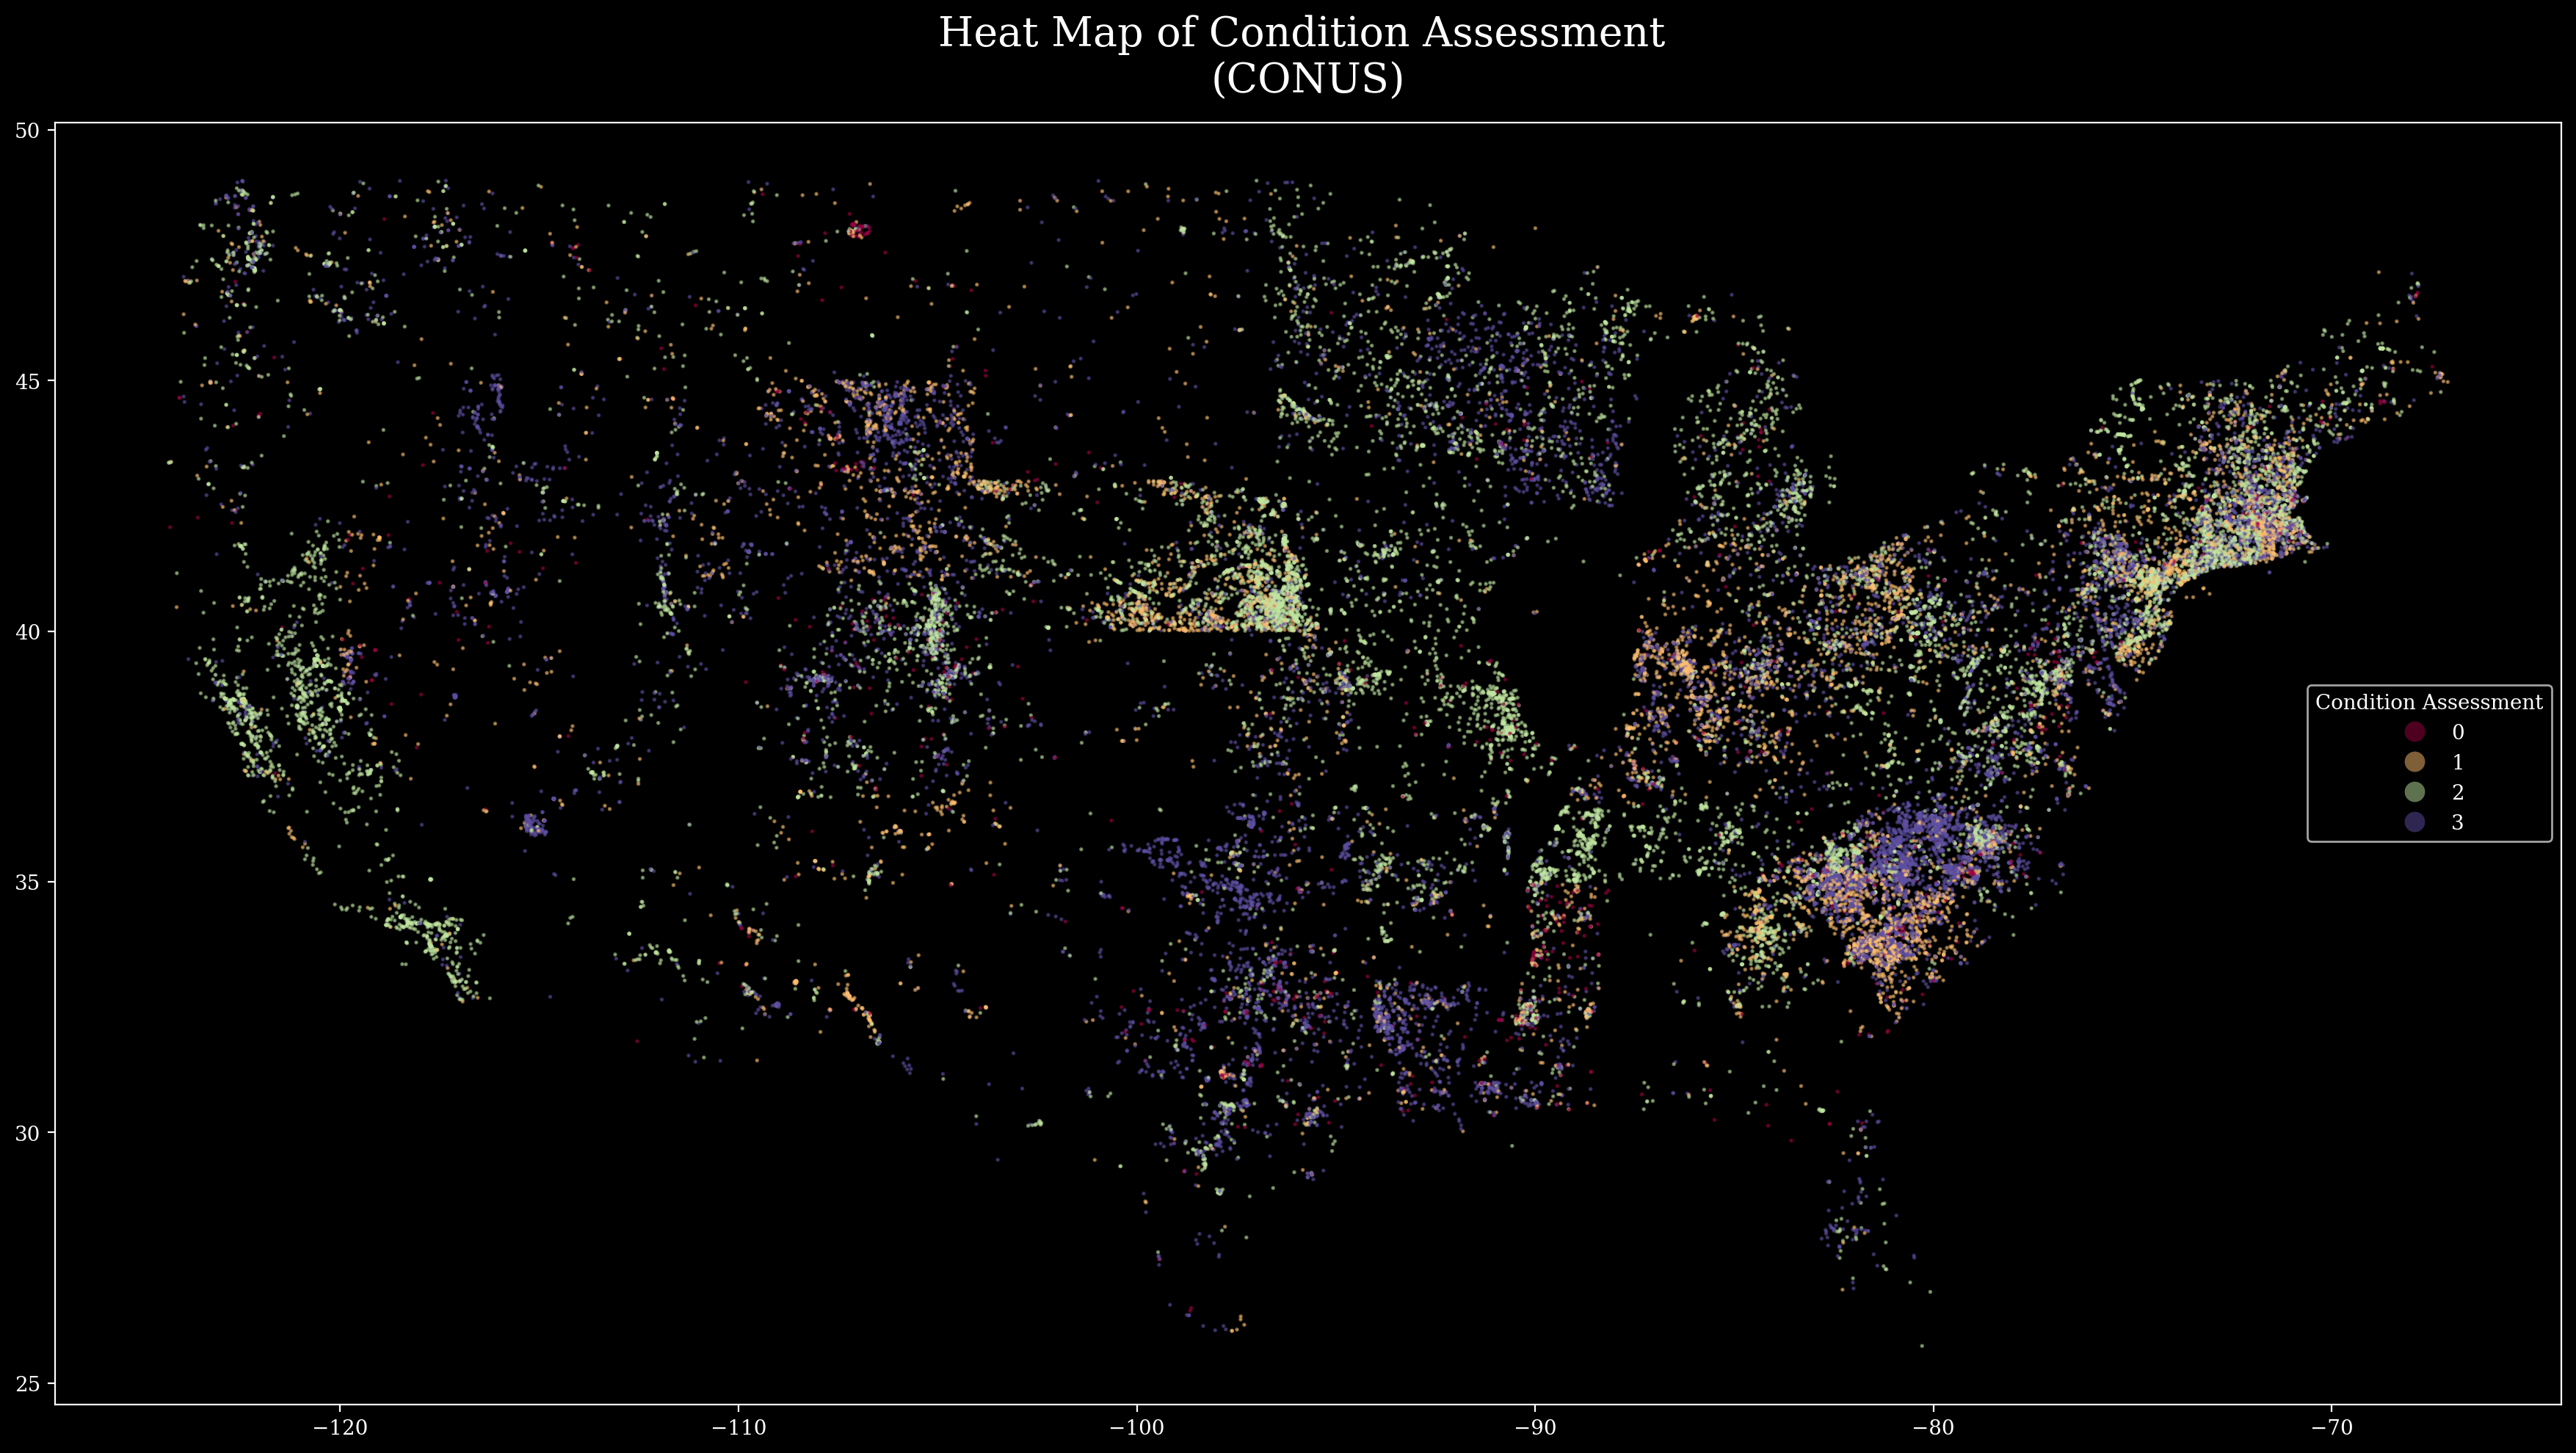

In [224]:
plt.clf()
ax = geo_df[mask].plot(column= 'Condition Assessment', cmap = 'Spectral', categorical= True, markersize = 1, alpha = 0.5,
                       legend= True, legend_kwds={'loc':'center right', 'fmt':'{:.0f}'})
ax.set_title('Heat Map of Condition Assessment \n(CONUS)', fontdict={'fontweight':'normal'})

leg = ax.get_legend()
leg.set_title('Condition Assessment')
plt.show()
# Note: Unsatisfactory -> Poor -> Fair -> Satisfactory 

In [253]:
states = pd.read_clipboard(sep = '\t')
states_avg = gp.GeoDataFrame(states, geometry=gp.points_from_xy(states.Longitude,states.Latitude)).drop(columns=['Latitude', 'Longitude'])
tmp = np.round(primary[['State', 'Hazard Potential Classification', 'Condition Assessment']].groupby('State').mean(),2)
pd.merge(states_avg, tmp,left_on='State',right_index=True, how ='left')

State                     geometry  \
0                Alabama   POINT (-86.79113 32.80667)   
1                 Alaska  POINT (-152.40442 61.37072)   
2                Arizona  POINT (-111.43122 33.72976)   
3               Arkansas    POINT (-92.37312 34.9697)   
4             California   POINT (-119.68156 36.1162)   
5               Colorado   POINT (-105.3111 39.05981)   
6            Connecticut   POINT (-72.75537 41.59778)   
7               Delaware   POINT (-75.50714 39.31852)   
8   District of Columbia   POINT (-77.02682 38.89744)   
9                Florida   POINT (-81.68678 27.76628)   
10               Georgia   POINT (-83.64307 33.04062)   
11                Hawaii  POINT (-157.49834 21.09432)   
12                 Idaho  POINT (-114.47883 44.24046)   
13              Illinois   POINT (-88.98614 40.34946)   
14               Indiana   POINT (-86.25828 39.84943)   
15                  Iowa   POINT (-93.21053 42.01154)   
16                Kansas    POINT (-96.72649 38.5266)   
17              Kentucky   POINT (-84.67007 37.66814)   
18             Louisiana    POINT (-91.8678 31.16955)   
19                 Maine   POINT (-69.38193 44.69395)   
20              Maryland    POINT (-76.8021 39.06395)   
21         Massachusetts   POINT (-71.53011 42.23017)   
22              Michigan    POINT (-84.5361 43.32662)   
23             Minnesota   POINT (-93.90019 45.69445)   
24           Mississippi    POINT (-89.6787 32.74165)   
25              Missouri   POINT (-92.28837 38.45608)   
26               Montana  POINT (-110.45435 46.92192)   
27              Nebraska   POINT (-98.26808 41.12537)   
28                Nevada  POINT (-117.05537 38.31352)   
29         New Hampshire    POINT (-71.5639 43.45249)   
30            New Jersey    POINT (-74.52101 40.2989)   
31            New Mexico  POINT (-106.24848 34.84052)   
32              New York   POINT (-74.94805 42.16573)   
33        North Carolina   POINT (-79.80642 35.63007)   
34          North Dakota   POINT (-99.78401 47.52891)   
35                  Ohio   POINT (-82.76492 40.38878)   
36              Oklahoma   POINT (-96.92892 35.56534)   
37                Oregon  POINT (-122.07094 44.57202)   
38          Pennsylvania   POINT (-77.20976 40.59075)   
39          Rhode Island   POINT (-71.51178 41.68089)   
40        South Carolina   POINT (-80.94501 33.85689)   
41          South Dakota   POINT (-99.43883 44.29978)   
42             Tennessee   POINT (-86.69234 35.74784)   
43                 Texas   POINT (-97.56346 31.05449)   
44                  Utah  POINT (-111.86243 40.15003)   
45               Vermont   POINT (-72.71069 44.04588)   
46              Virginia   POINT (-78.16997 37.76934)   
47            Washington   POINT (-121.49049 47.4009)   
48         West Virginia   POINT (-80.95445 38.49123)   
49             Wisconsin   POINT (-89.61651 44.26854)   
50               Wyoming  POINT (-107.30249 42.75597)   

    Hazard Potential Classification  Condition Assessment  
0                              1.70                  1.83  
1                              1.06                  2.16  
2                              1.55                  1.99  
3                              0.88                  2.19  
4                              1.26                  2.03  
5                              0.78                  2.22  
6                              1.25                  2.14  
7                              1.75                  2.78  
8                               NaN                   NaN  
9                              1.30                  2.25  
10                             1.80                  1.68  
11                             1.90                  1.34  
12                             0.82                  2.55  
13                             0.50                  1.95  
14                             0.87                  1.77  
15                             1.08                  2.15  
16                             1.4